<a href="https://colab.research.google.com/github/bhanuswaroop1247/sales-forecasting-with-prophet/blob/main/Predictive_Analytics_for_Retail_Sales_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #1: IMPORT LIBRARIES AND DATASET

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime

In [ ]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TASK #2.1: IMPORT SALES TRAINING DATA

In [ ]:
# You have to include the full link to the csv file containing your dataset
sales_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science for Business Package/3. Sales Department Data/train.csv')

In [ ]:
sales_train_df.head(5)
# almost a million observation
# 1115 unique stores
# Note that sales is the target variable (that's what we are trying to predict)

# Id: transaction ID (combination of Store and date)
# Store: unique store Id
# Sales: sales/day, this is the target variable
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
# Data Source: https://www.kaggle.com/c/rossmann-store-sales/data



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales_train_df.tail(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017199,1106,2,2013-01-01,0,0,0,0,a,1
1017200,1107,2,2013-01-01,0,0,0,0,a,1
1017201,1108,2,2013-01-01,0,0,0,0,a,1
1017202,1109,2,2013-01-01,0,0,0,0,a,1
1017203,1110,2,2013-01-01,0,0,0,0,a,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
sales_train_df.info()
# 9 columns in total
# 8 features, each contains 1017209 data points
# 1 target variable (sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
sales_train_df.describe()
# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


TASK #2.2: IMPORT STORE INFORMATION DATA

In [ ]:
store_info_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science for Business Package/3. Sales Department Data/store.csv')
# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store




In [ ]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
# Let's do the same for the store_info_df data
# Note that the previous dataframe includes the transactions recorded per day (in millions)
# This dataframe only includes information about the unique 1115 stores that are part of this study


In [ ]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_info_df.describe()
# on average, the competition distance is 5404 meters away (5.4 kms)

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# #2: EXPLORE DATASET

 #2.1: EXPLORE SALES TRAINING DATA

<Axes: >

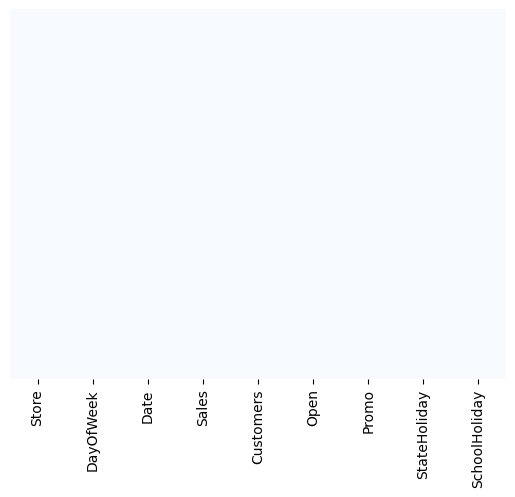

In [ ]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(sales_train_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Sales'}>],
       [<Axes: title={'center': 'Customers'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Promo'}>],
       [<Axes: title={'center': 'SchoolHoliday'}>, <Axes: >, <Axes: >]],
      dtype=object)

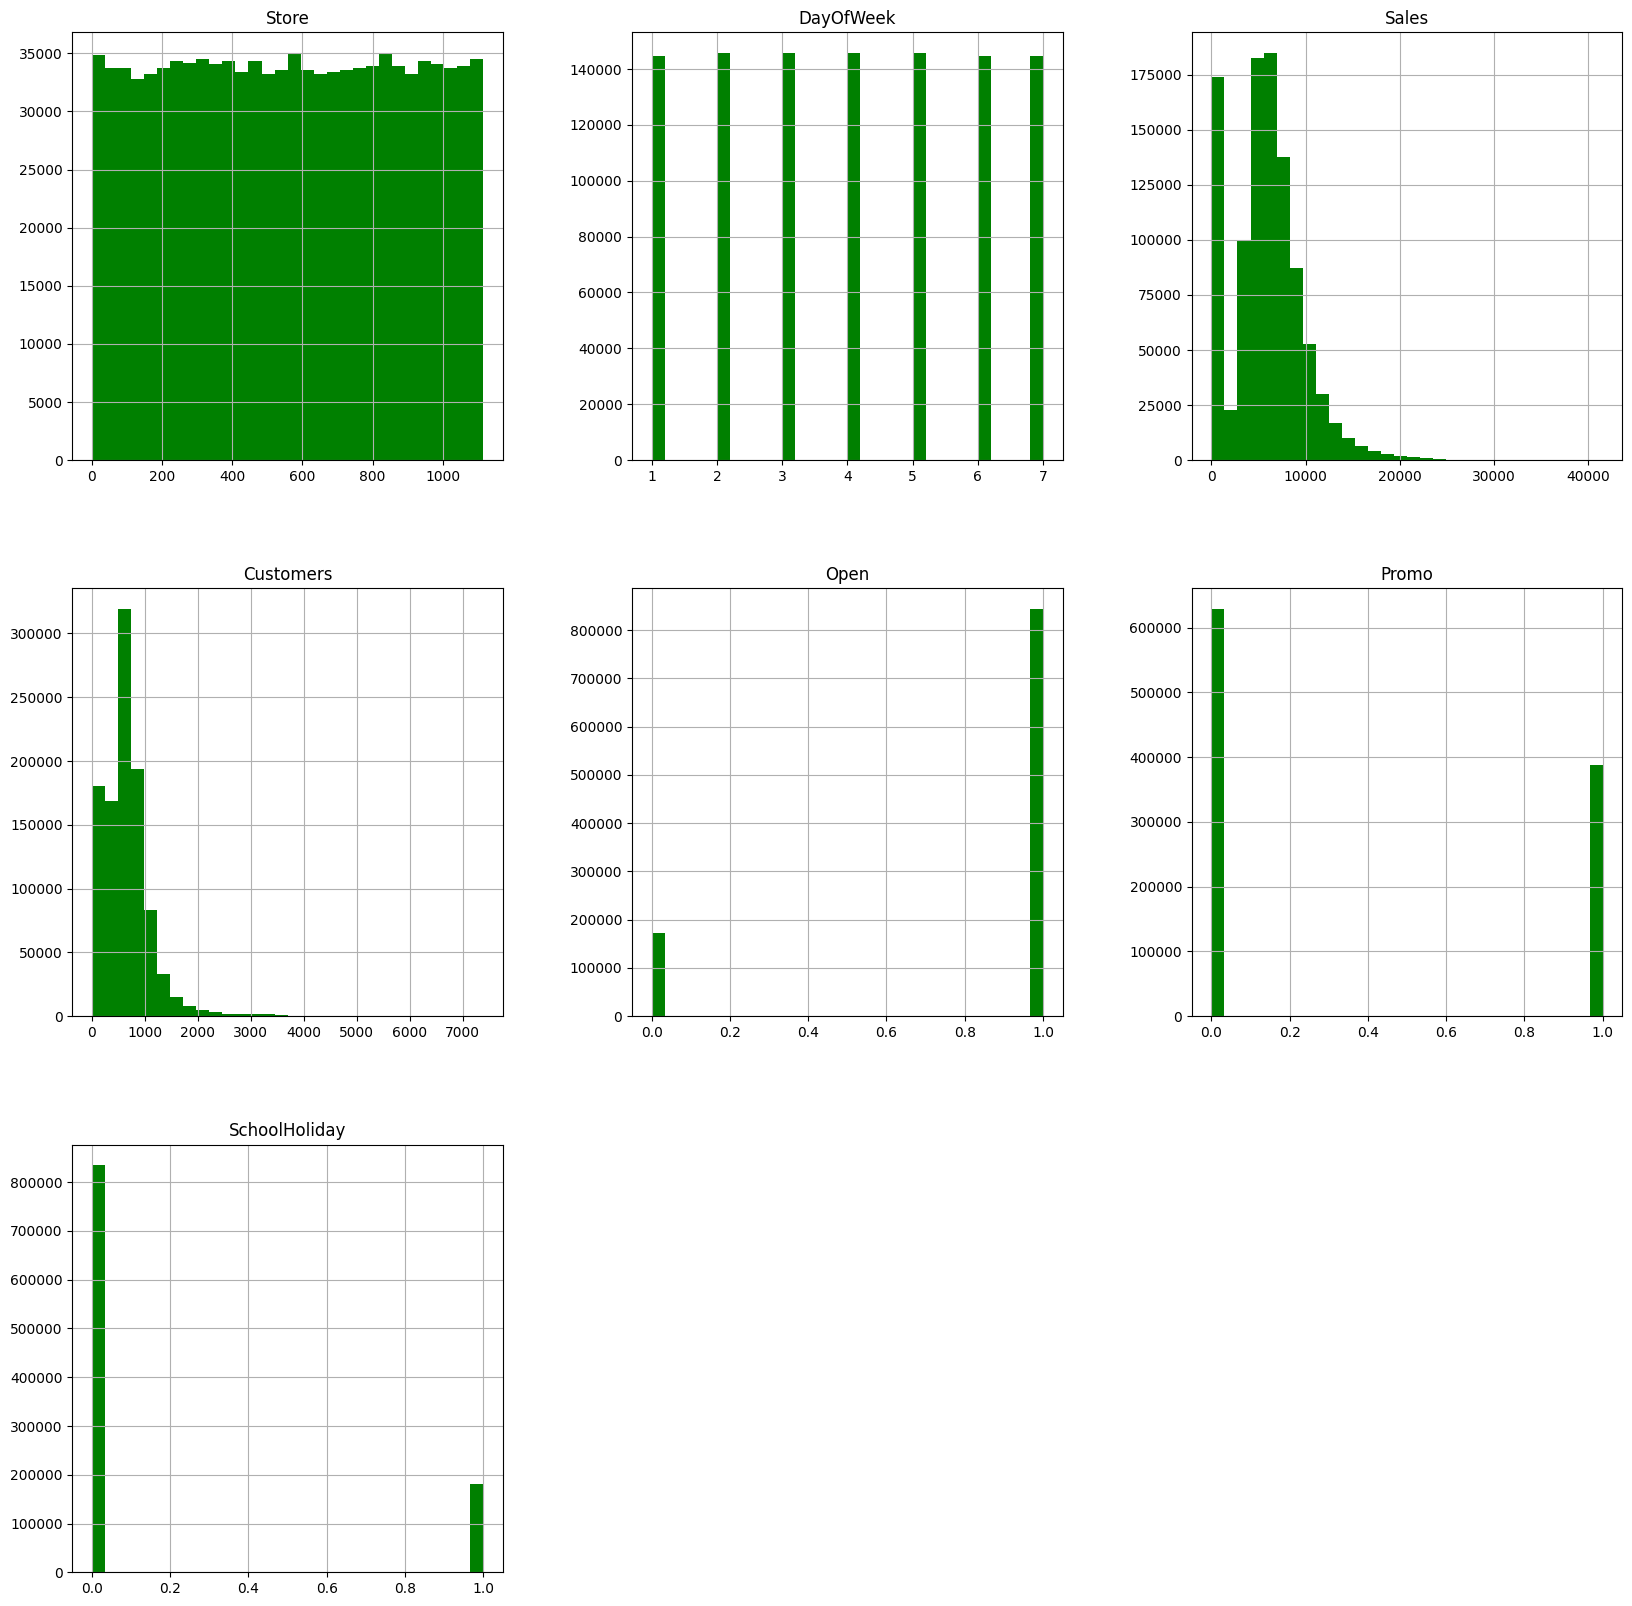

In [ ]:

# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation)
# Stores are open ~80% of the time
# Data is equally distributed among all stores (no bias)
# Promo #1 was running ~40% of the time
# Average sales around 5000-6000 Euros
# School holidays are around ~18% of the time
sales_train_df.hist(bins = 30, figsize = (20,20), color = 'g')


In [ ]:
sales_train_df['Customers'].max()

7388

In [ ]:
# Let's see how many stores are open and closed!
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [ ]:
# Count the number of stores that are open and closed
print('Total = ',len(sales_train_df))
print('Number of Open Stores = ',len(open_train_df))
print('Nuber of Closed Stores = ',len(closed_train_df))

Total =  1017209
Number of Open Stores =  844392
Nuber of Closed Stores =  172817


In [ ]:
# only keep open stores and remove closed stores
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [ ]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [ ]:
# Let's drop the open column since it has no meaning now
sales_train_df.drop(['Open'], axis = 1, inplace = True)

In [ ]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [ ]:
sales_train_df.describe()
# Average sales = 6955 Euros,	average number of customers = 762	(went up)

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000



 #2.2: EXPLORE STORES INFORMATION DATA

<Axes: >

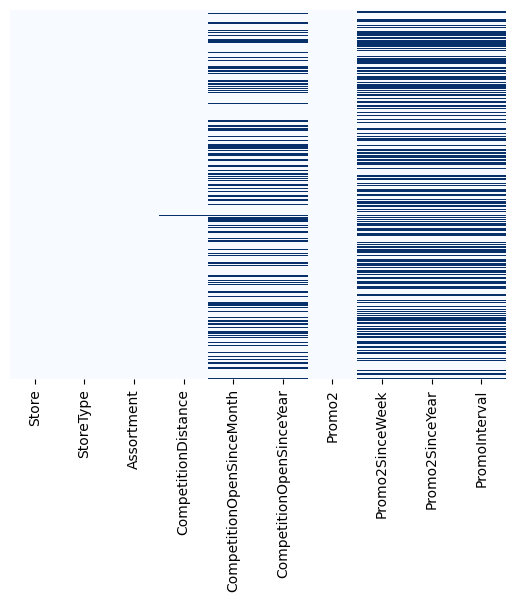

In [ ]:
# Let's see if we have any missing data in the store information dataframe!
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [ ]:
# Let's take a look at the missing values in the 'CompetitionDistance'
# Only 3 rows are missing
store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# Let's take a look at the missing values in the 'CompetitionOpenSinceMonth'
# many rows are missing = 354 (almost one third of the 1115 stores)
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
store_info_df[store_info_df['Promo2']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
# It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to zero
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing
# Let's set these values to zeros
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']

In [ ]:
for str in str_cols:
  store_info_df[str].fillna(0, inplace = True)

<Axes: >

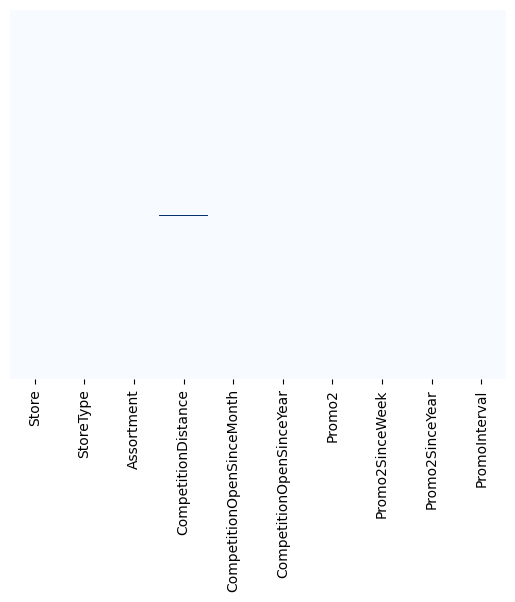

In [ ]:
# There are 3 rows with 'competitionDistance' values missing, let's fill them up with with average values of the 'CompetitionDistance' column
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [ ]:
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

<Axes: >

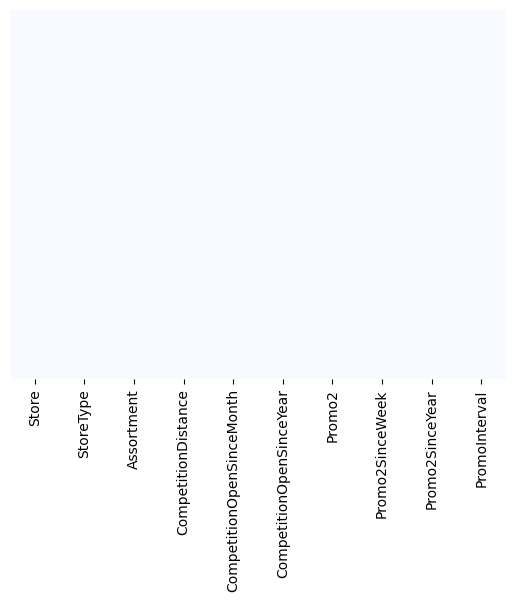

In [ ]:
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

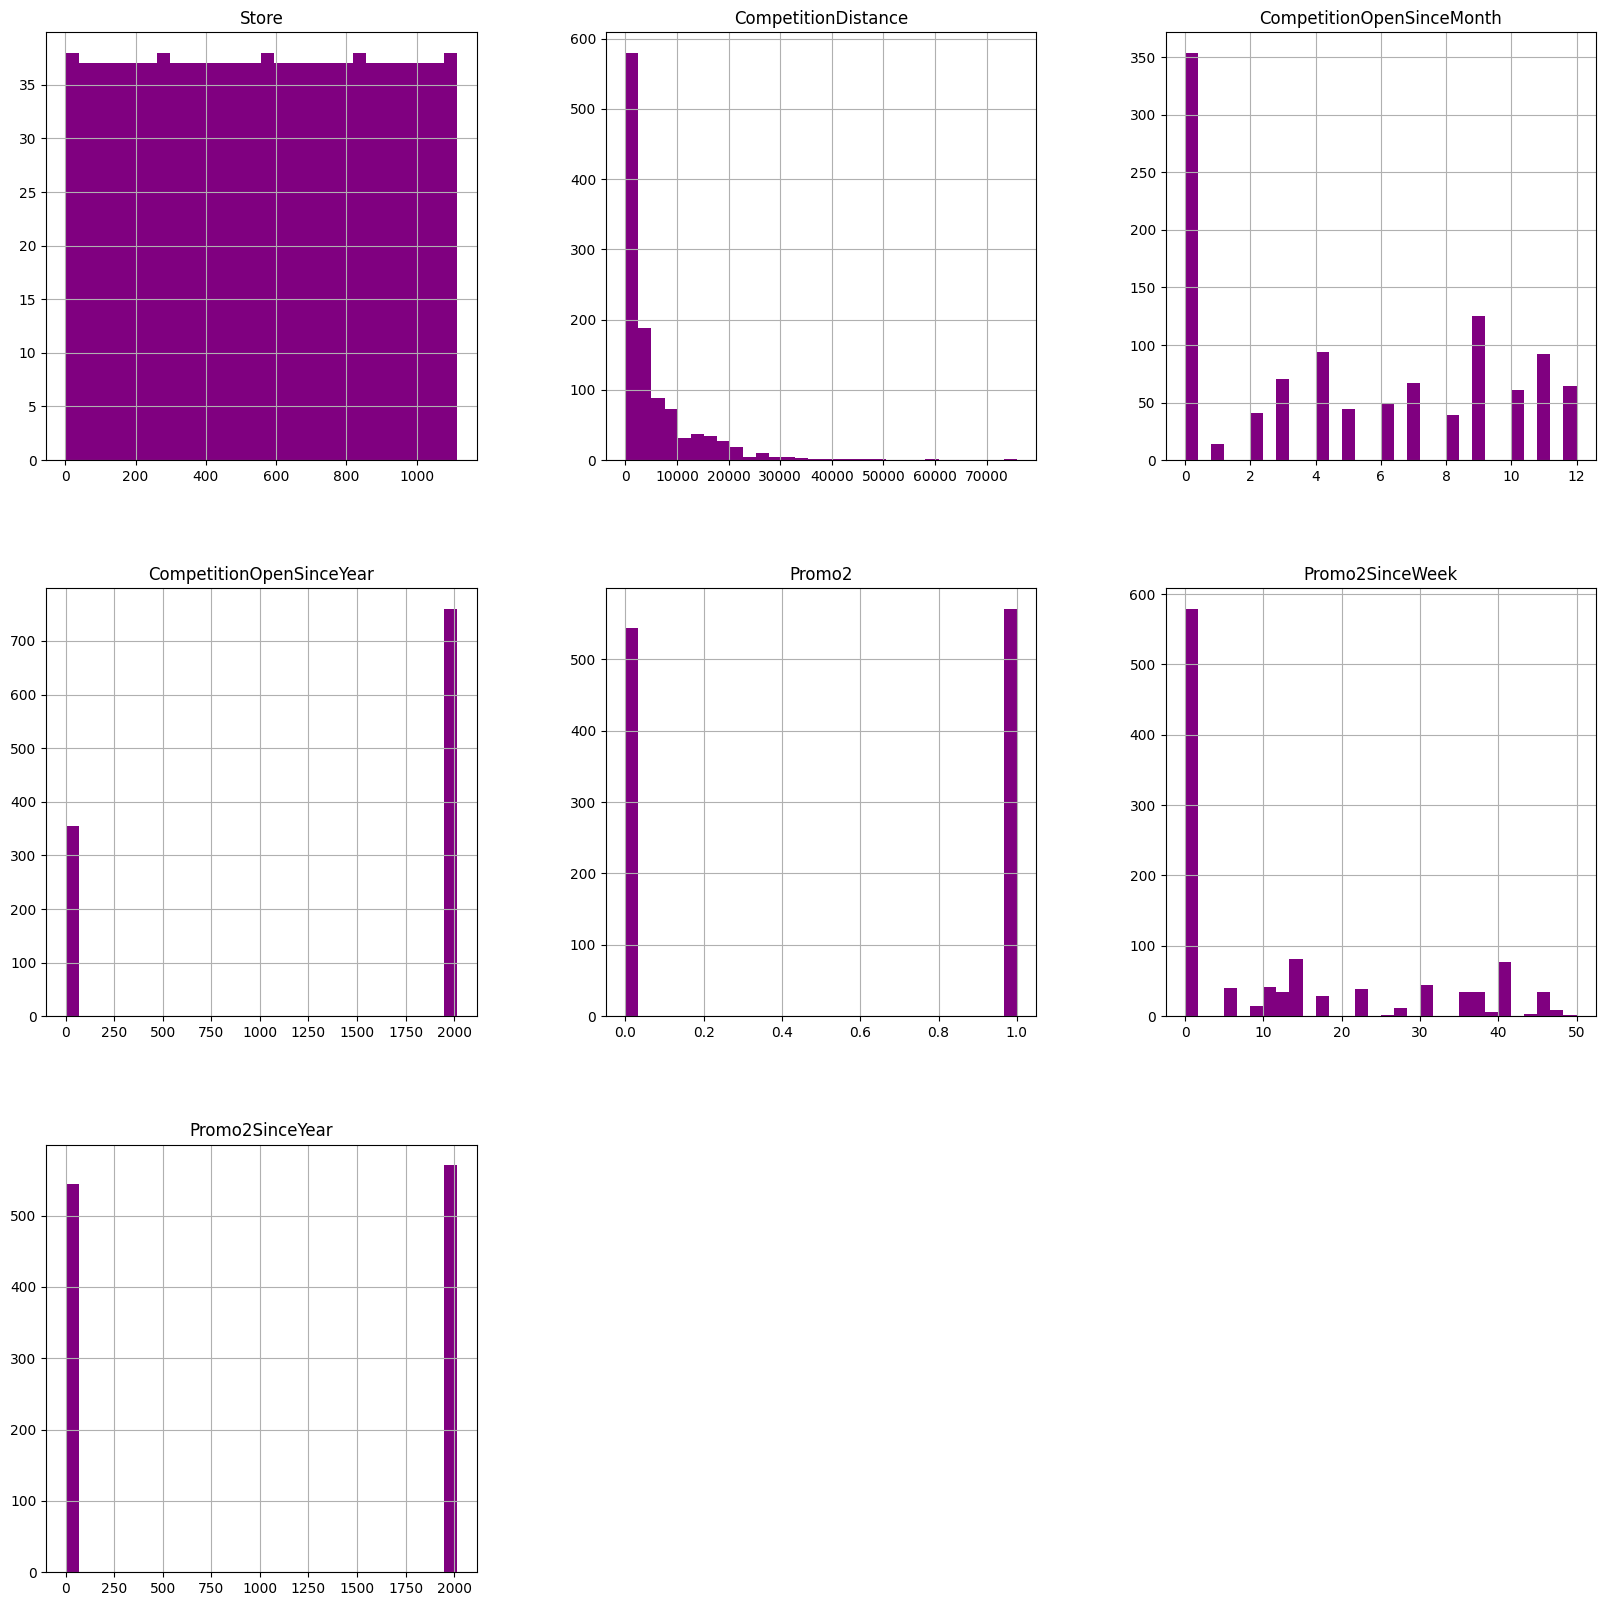

In [ ]:
# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)
store_info_df.hist(bins = 30, figsize = (20,20), color = 'purple')

 2.3: EXPLORE MERGED DATASET

In [ ]:
# Let's merge both data frames together based on 'store'
sales_train_all_df = pd.merge(sales_train_df, store_info_df, on = 'Store', how = 'inner')

In [ ]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
844388,733,2,2013-01-01,10765,2377,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
844389,769,2,2013-01-01,5035,1248,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844390,948,2,2013-01-01,4491,1039,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


In [ ]:
# exclude non-numeric columns before calculating correlations
correlations = sales_train_all_df.drop(['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], axis=1).corr()['Sales'].sort_values()
correlations
# customers and promo are positively correlated with the sales
# Promo2 does not seem to be effective at all

,Sales
DayOfWeek,-0.178736
Promo2SinceYear,-0.127621
Promo2,-0.127596
Promo2SinceWeek,-0.058476
CompetitionDistance,-0.036343
CompetitionOpenSinceMonth,-0.018370
CompetitionOpenSinceYear,0.005266
Store,0.007710
SchoolHoliday,0.038617
Promo,0.368145


<Axes: >

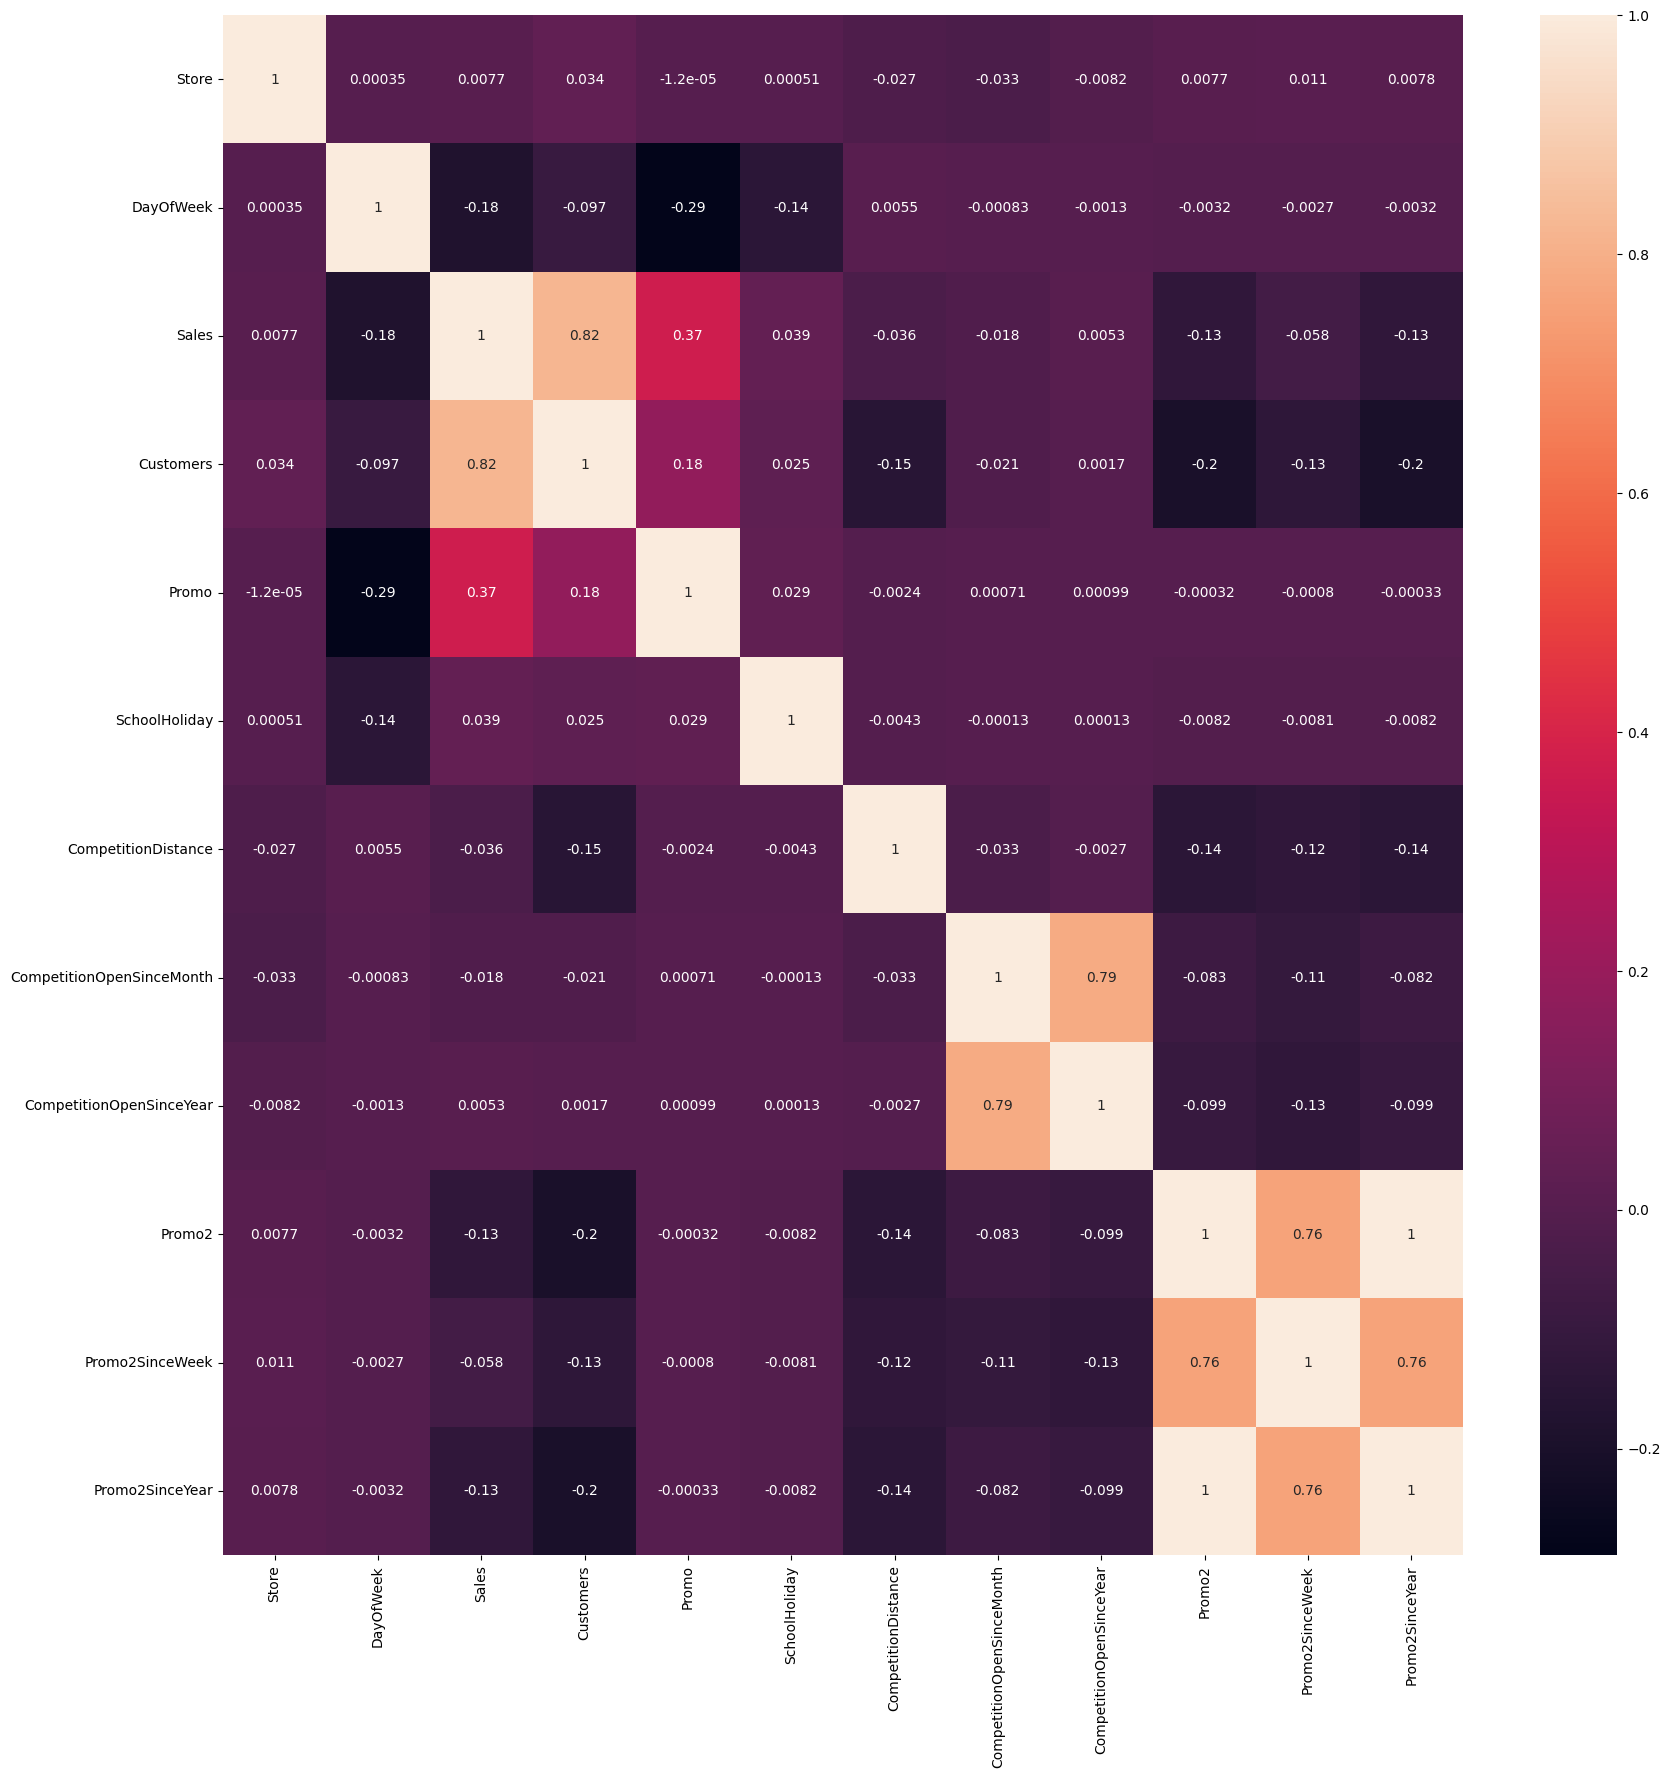

In [ ]:
correlations = sales_train_all_df.drop(['Date', 'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], axis=1).corr()
f,ax  = plt.subplots(figsize = (20,20))
sns.heatmap(correlations, annot = True)
# Customers/Prmo2 and sales are strongly correlated

In [ ]:
# Let's separate the year and put it into a separate column
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year

In [ ]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   StoreType                  844392 non-null  object 
 9   Assortment                 844392 non-null  object 
 10  CompetitionDistance        844392 non-null  float64
 11  CompetitionOpenSinceMonth  844392 non-null  float64
 12  CompetitionOpenSinceYear   844392 non-null  float64
 13  Promo2                     84

In [ ]:
# Let's do the same for the Day and Month
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [ ]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   StoreType                  844392 non-null  object 
 9   Assortment                 844392 non-null  object 
 10  CompetitionDistance        844392 non-null  float64
 11  CompetitionOpenSinceMonth  844392 non-null  float64
 12  CompetitionOpenSinceYear   844392 non-null  float64
 13  Promo2                     84

Text(0, 0.5, 'Customers')

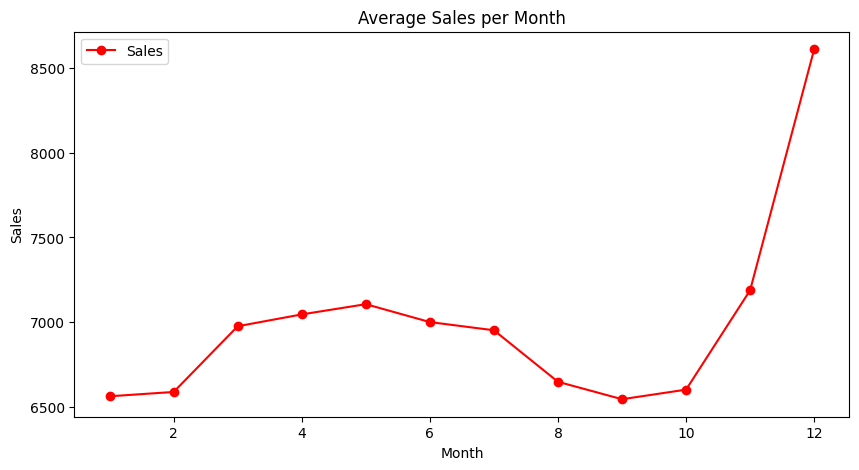

<Figure size 640x480 with 0 Axes>

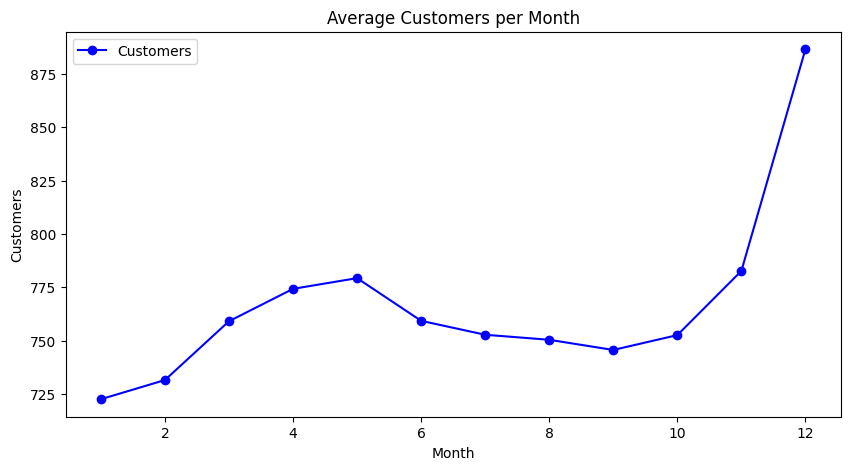

In [ ]:
# Let's take a look at the average sales and number of customers per month
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column
# It looks like sales and number of customers peak around christmas timeframe
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5),marker = 'o', color = 'r')
axis.set_title('Average Sales per Month')
axis.set_xlabel('Month')
axis.set_ylabel('Sales')

plt.figure()

axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5),marker = 'o', color = 'b')
axis.set_title('Average Customers per Month')
axis.set_xlabel('Month')
axis.set_ylabel('Customers')

Text(0, 0.5, 'Customers')

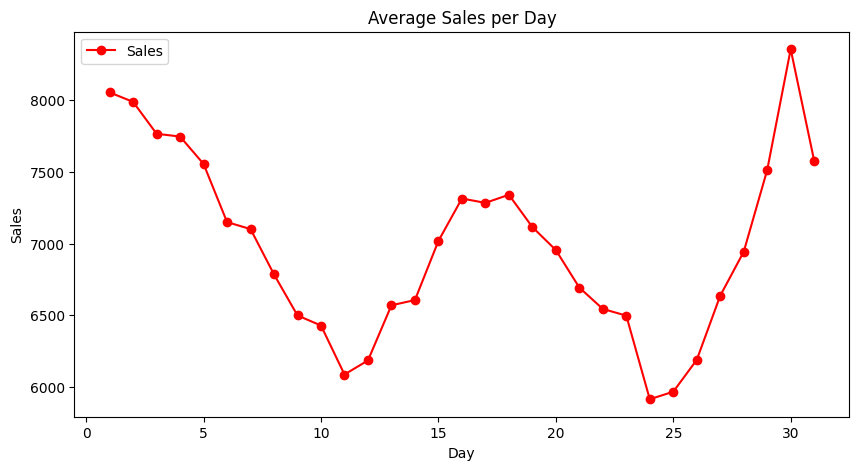

<Figure size 640x480 with 0 Axes>

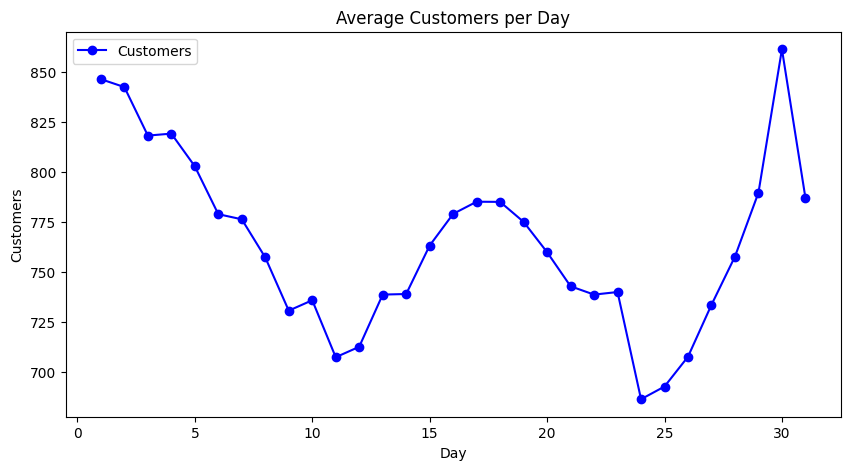

In [ ]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month
# Most customers and sales are around 30th and 1st of the month
axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5),marker = 'o', color = 'r')
axis.set_title('Average Sales per Day')
axis.set_xlabel('Day')
axis.set_ylabel('Sales')

plt.figure()

axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5),marker = 'o', color = 'b')
axis.set_title('Average Customers per Day')
axis.set_xlabel('Day')
axis.set_ylabel('Customers')

Text(0, 0.5, 'Customers')

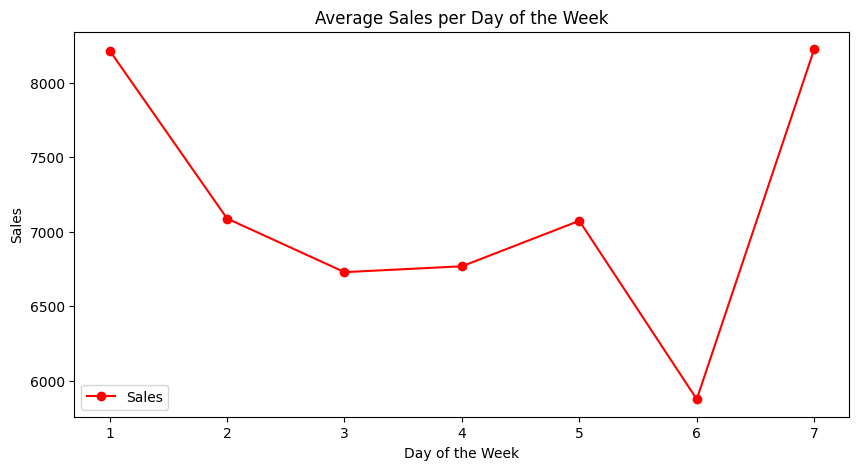

<Figure size 640x480 with 0 Axes>

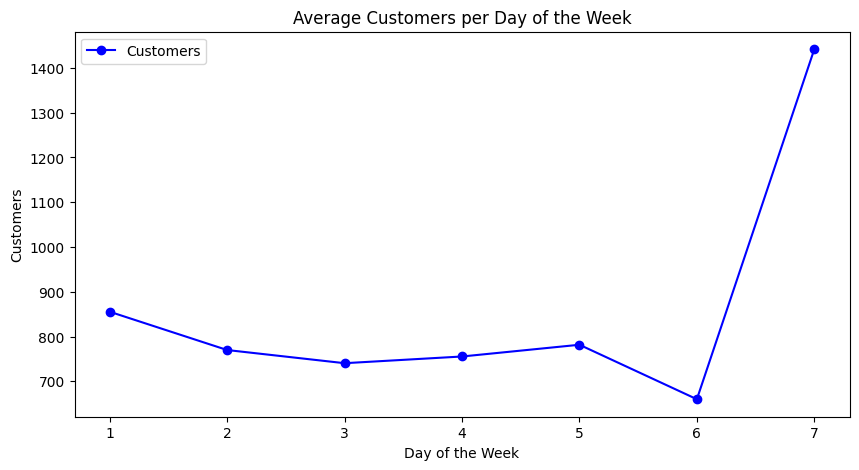

In [ ]:
# Let's do the same for the day of the week  (note that 7 = Sunday)
axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5),marker = 'o', color = 'r')
axis.set_title('Average Sales per Day of the Week')
axis.set_xlabel('Day of the Week')
axis.set_ylabel('Sales')

plt.figure()

axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5),marker = 'o', color = 'b')
axis.set_title('Average Customers per Day of the Week')
axis.set_xlabel('Day of the Week')
axis.set_ylabel('Customers')

<Axes: xlabel='Date'>

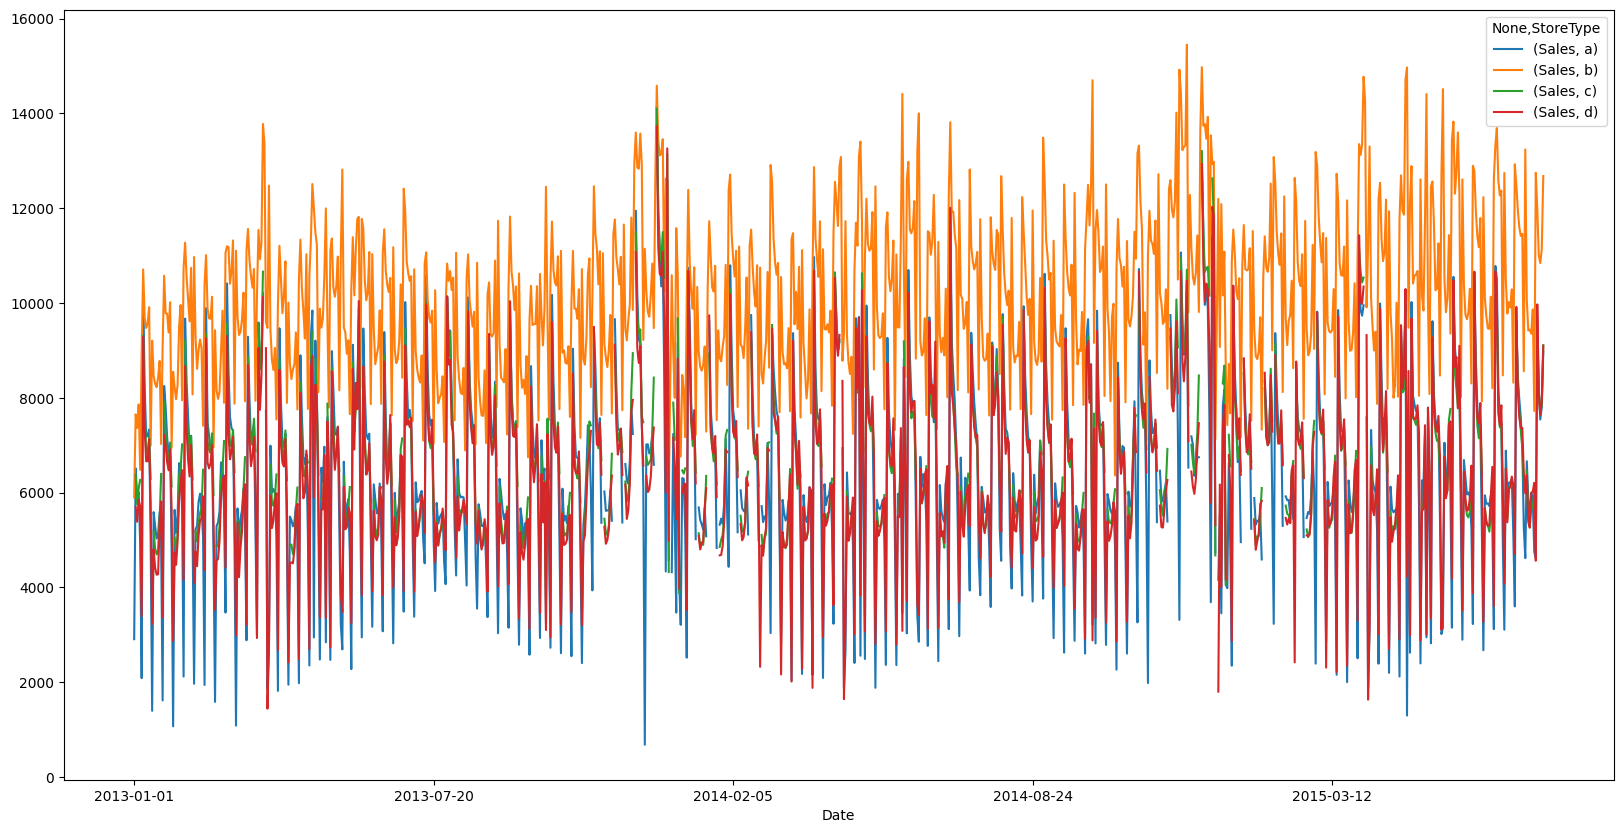

In [ ]:
fig , ax = plt.subplots(figsize = (20,10))
sales_train_all_df.groupby(['Date','StoreType'])[['Sales']].mean().unstack().plot(ax = ax)

<Axes: xlabel='Promo', ylabel='Sales'>

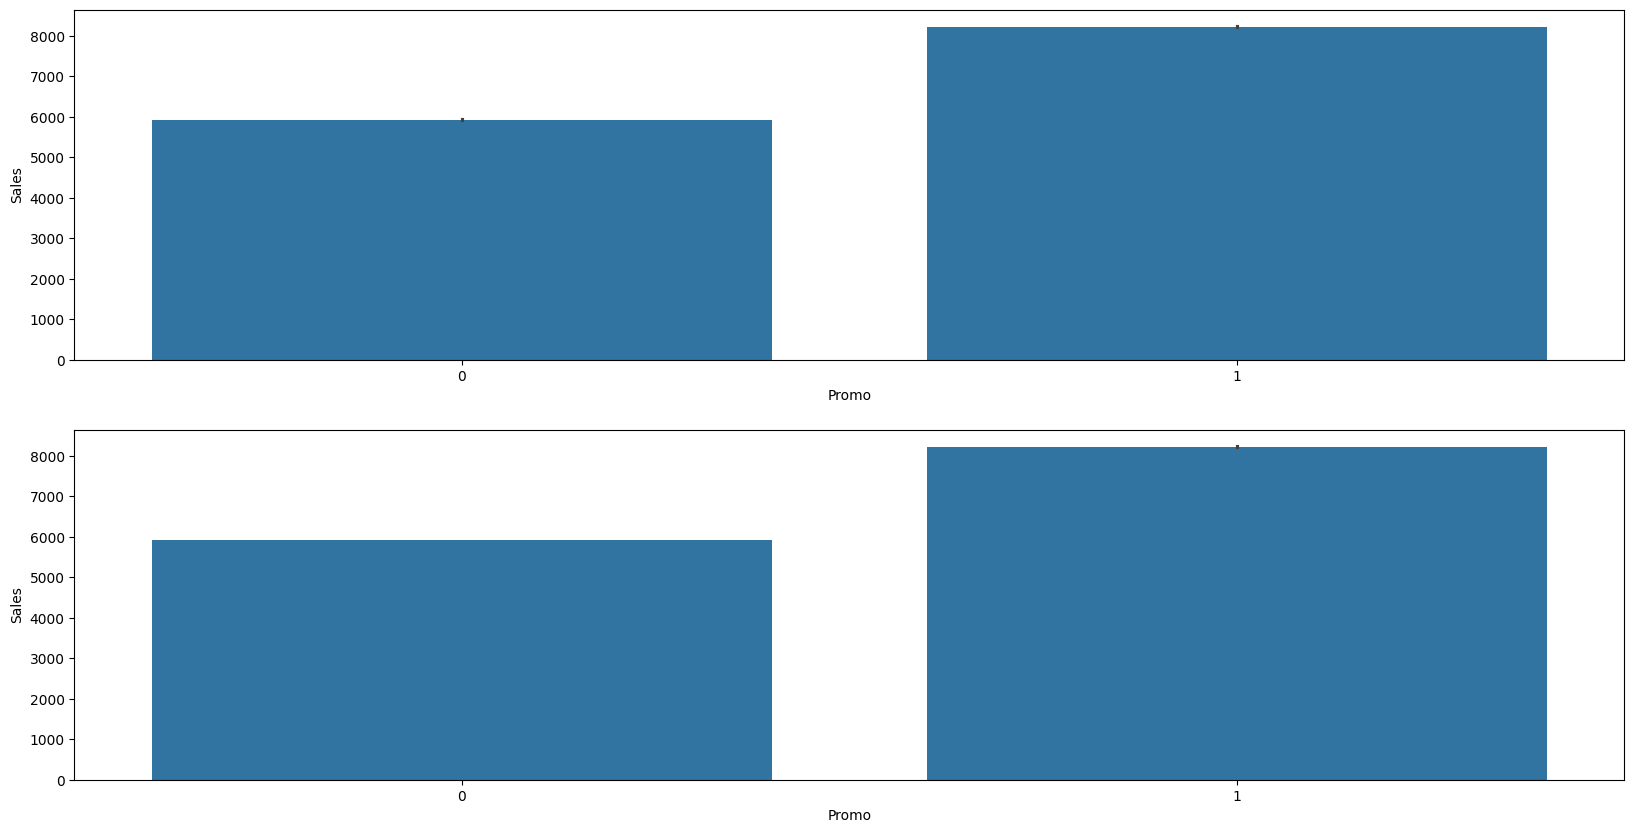

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)
plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

<Axes: xlabel='Promo', ylabel='Sales'>

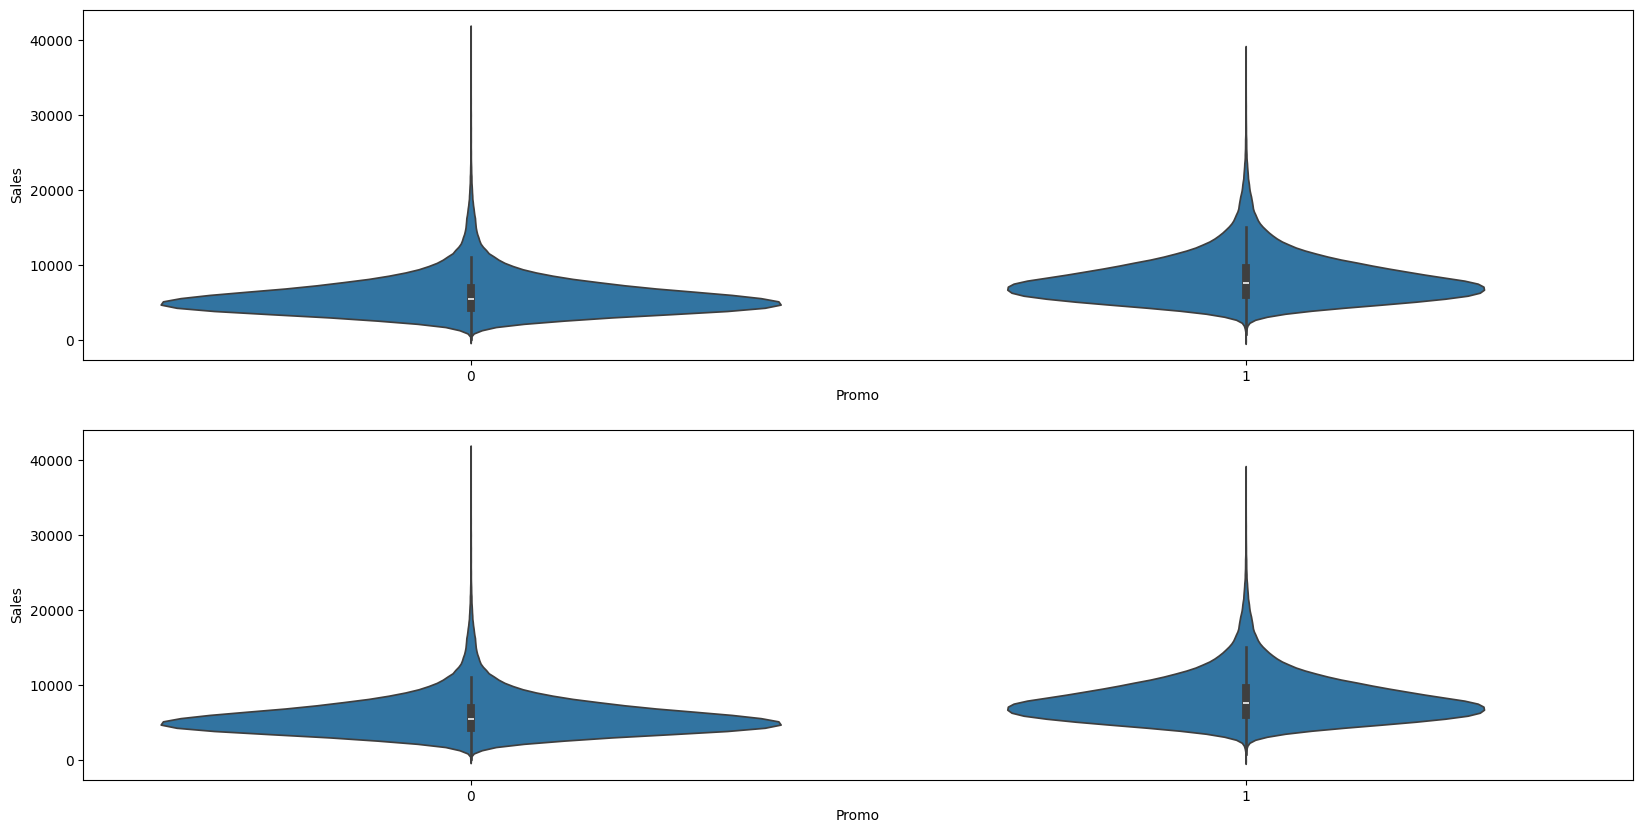

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)
plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

#  #3: TRAIN THE MODEL

In [ ]:
# import prophet
!pip uninstall fbprophet -y
!pip install prophet
from prophet import Prophet

In [ ]:
def sales_predictions(Store_ID,sales_df,periods):
  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df.rename(columns = {'Date':'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')

  model = Prophet(interval_width = 0.95)
  model.fit(sales_df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)

  figure = model.plot(forecast,xlabel= 'Date', ylabel= 'Sales')
  figure2 = model.plot_components(forecast)

  return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9fknhkgm/7fsl6_fq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9fknhkgm/moo7fhy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19092', 'data', 'file=/tmp/tmp9fknhkgm/7fsl6_fq.json', 'init=/tmp/tmp9fknhkgm/moo7fhy_.json', 'output', 'file=/tmp/tmp9fknhkgm/prophet_modelufnc1q83/prophet_model-20250930094647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat
0,2013-01-02,5146.703601
1,2013-01-03,5098.810327
2,2013-01-04,5282.788322
3,2013-01-05,4436.043145
4,2013-01-07,6057.861253
...,...,...
839,2015-09-25,6025.772603
840,2015-09-26,5260.033637
841,2015-09-27,5805.565344
842,2015-09-28,7019.045421


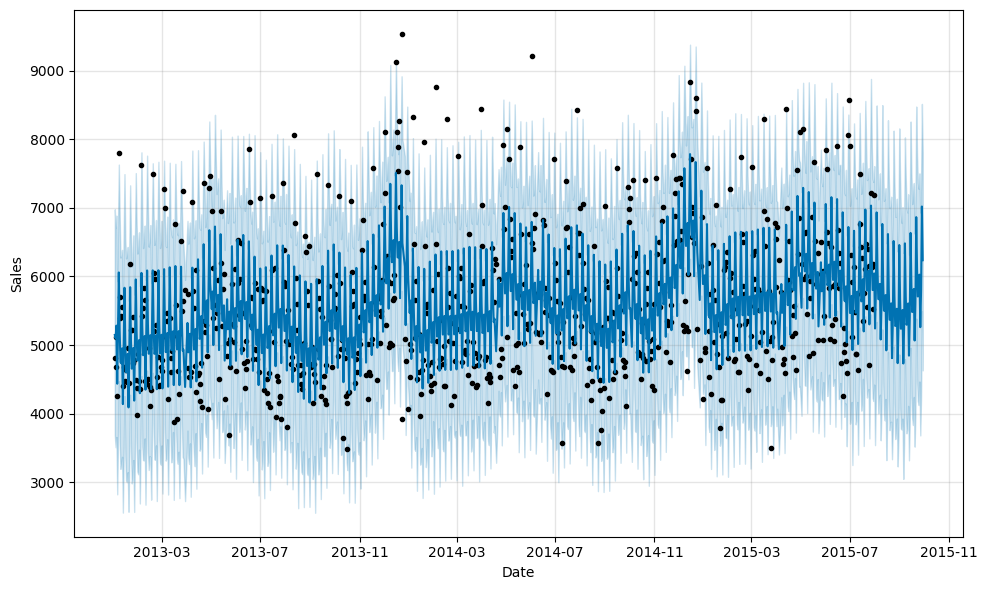

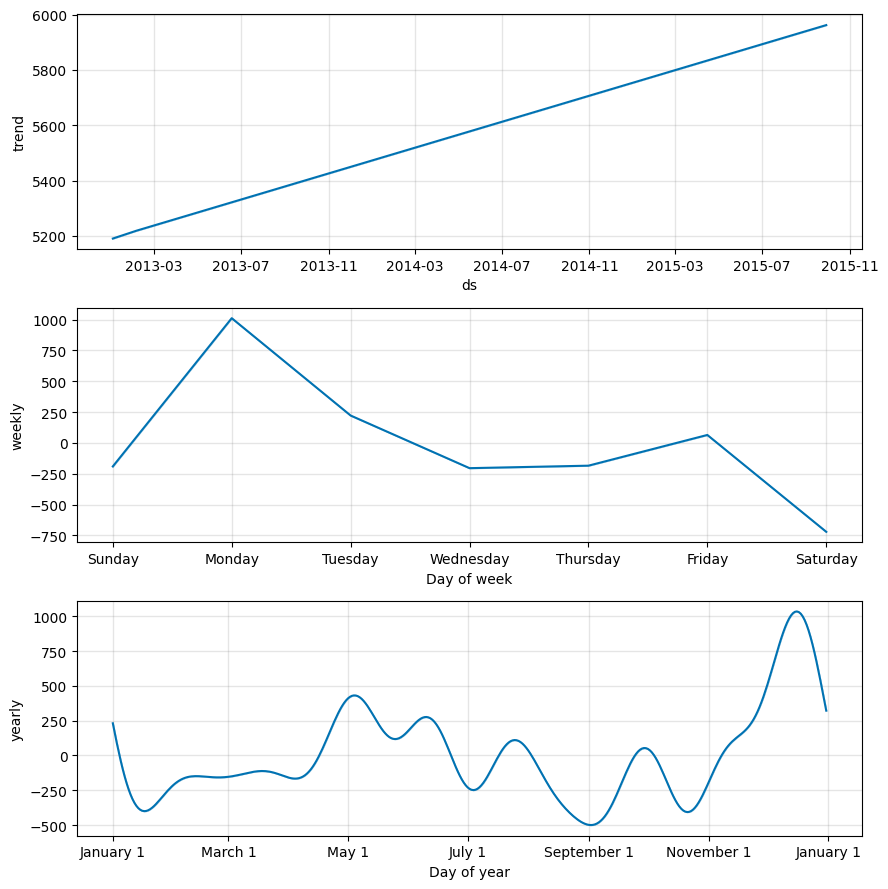

In [ ]:
sales_predictions(10,sales_train_all_df,60)[['ds', 'yhat']]


# #4: TRAIN THE MODEL PART B


   - StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
   - SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
  






In [ ]:
def sales_predictions(Store_ID,sales_df, holidays , periods):
  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df.rename(columns = {'Date':'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')

  model = Prophet(holidays= holidays,interval_width = 0.95)
  model.fit(sales_df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)

  figure = model.plot(forecast,xlabel= 'Date', ylabel= 'Sales')
  figure2 = model.plot_components(forecast)

  return forecast

In [ ]:
# Get all the dates pertaining to school holidays
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1].loc[:,'Date'].values

In [ ]:
school_holidays.shape

(163457,)

In [ ]:
# Get all the dates pertaining to state holidays
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] == 'a')|(sales_train_all_df['StateHoliday'] == 'b')|(sales_train_all_df['StateHoliday'] == 'c')].loc[:,'Date'].values

In [ ]:
state_holidays.shape

(910,)

In [ ]:
state_holidays = pd.DataFrame({'ds':pd.to_datetime(state_holidays),
                               'holiday':'state_holiday'})

In [ ]:
state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-06-04,state_holiday
2,2015-06-04,state_holiday
3,2015-06-04,state_holiday
4,2015-06-04,state_holiday
...,...,...
905,2013-01-01,state_holiday
906,2013-01-01,state_holiday
907,2013-01-01,state_holiday
908,2013-01-01,state_holiday


In [ ]:
state_holidays = pd.DataFrame({'ds': state_holidays['ds'],
                               'holiday':'state_holiday'})
state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-06-04,state_holiday
2,2015-06-04,state_holiday
3,2015-06-04,state_holiday
4,2015-06-04,state_holiday
...,...,...
905,2013-01-01,state_holiday
906,2013-01-01,state_holiday
907,2013-01-01,state_holiday
908,2013-01-01,state_holiday


In [ ]:
school_holidays = pd.DataFrame({'ds': pd.Series(school_holidays),
                               'holiday':'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-31,school_holiday
2,2015-07-31,school_holiday
3,2015-07-31,school_holiday
4,2015-07-31,school_holiday
...,...,...
163452,2013-01-01,school_holiday
163453,2013-01-01,school_holiday
163454,2013-01-01,school_holiday
163455,2013-01-01,school_holiday


In [ ]:
# concatenate both school and state holidays
school_state_holidays = pd.concat([state_holidays,school_holidays])

In [ ]:
school_state_holidays

,ds,holiday
0,2015-06-04 00:00:00,state_holiday
1,2015-06-04 00:00:00,state_holiday
2,2015-06-04 00:00:00,state_holiday
3,2015-06-04 00:00:00,state_holiday
4,2015-06-04 00:00:00,state_holiday
...,...,...
163452,2013-01-01,school_holiday
163453,2013-01-01,school_holiday
163454,2013-01-01,school_holiday
163455,2013-01-01,school_holiday


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9fknhkgm/e7nrk6ee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9fknhkgm/yqmaqjde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27766', 'data', 'file=/tmp/tmp9fknhkgm/e7nrk6ee.json', 'init=/tmp/tmp9fknhkgm/yqmaqjde.json', 'output', 'file=/tmp/tmp9fknhkgm/prophet_modelrcsrwidv/prophet_model-20250930100756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:07:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat
0,2013-01-02,6535.549173
1,2013-01-03,6266.762506
2,2013-01-04,6483.264539
3,2013-01-05,4300.480735
4,2013-01-07,7185.446347
...,...,...
865,2015-10-25,4015.860082
866,2015-10-26,5405.300331
867,2015-10-27,4694.065732
868,2015-10-28,4560.748038


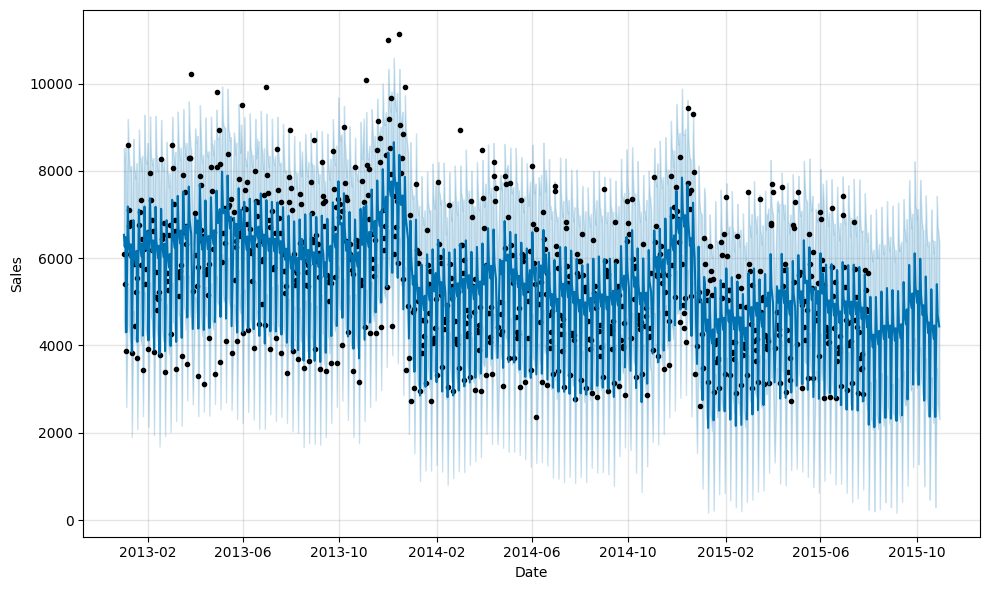

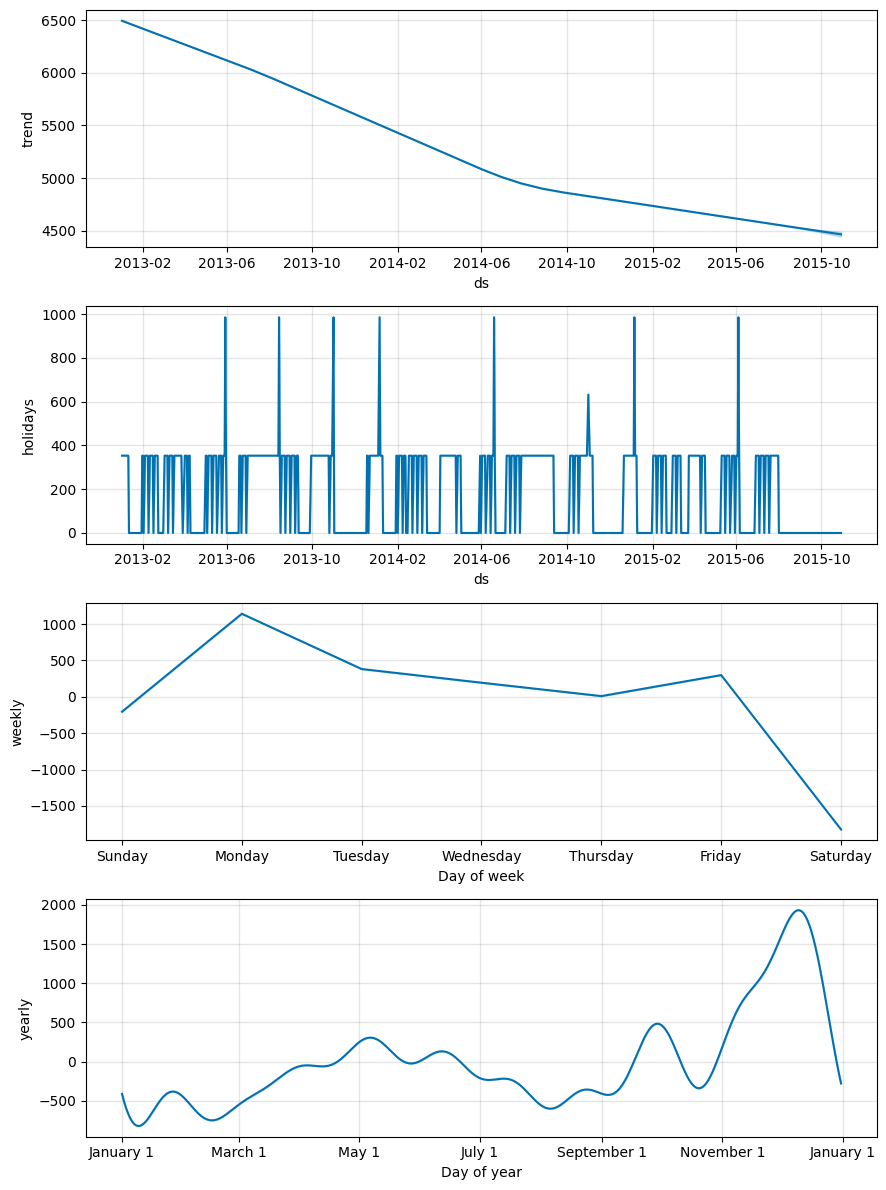

In [ ]:
# Let's make predictions using holidays for a specific store
sales_predictions(6,sales_train_all_df,school_state_holidays,90)[['ds', 'yhat']]